In [7]:
from huggingface_hub import notebook_login

In [9]:
notebook_login()

In [3]:
import torch
import torch.nn as nn
import torch.nn.utils.prune as prune
from transformers import AutoModelForCausalLM, AutoTokenizer
import numpy as np
from typing import Union, Dict, List, Optional, Tuple
import gc
import os
import copy


def calculate_model_size(model: nn.Module) -> Dict[str, float]:
    """
    Вычисляет размер модели в параметрах и мегабайтах.
    """
    total_params = 0
    total_size_mb = 0
    non_zero_params = 0
    
    for param in model.parameters():
        total_params += param.numel()
        non_zero_params += (param != 0).sum().item()
        # Размер в байтах (float32 = 4 байта, float16 = 2 байта)
        param_size = param.numel() * param.element_size()
        total_size_mb += param_size / (1024 * 1024)
    
    # Реальный размер с учетом разреженности (приблизительный)
    sparsity = 1 - (non_zero_params / total_params)
    effective_size_mb = total_size_mb * (1 - sparsity * 0.5)  # Sparse storage saves ~50% for sparse matrices
    
    return {
        'total_params': total_params,
        'non_zero_params': non_zero_params,
        'total_params_millions': total_params / 1e6,
        'size_mb': total_size_mb,
        'effective_size_mb': effective_size_mb,
        'size_gb': total_size_mb / 1024,
        'sparsity': sparsity * 100
    }


def get_prunable_layers(model: nn.Module) -> List[Tuple[str, nn.Module]]:
    """
    Получает список слоев, которые можно прунить.
    Исключаем embeddings и последний слой для сохранения функциональности.
    """
    prunable_layers = []
    
    # Получаем все Linear слои
    all_linear_layers = [(name, module) for name, module in model.named_modules() 
                         if isinstance(module, nn.Linear)]
    
    # Исключаем критически важные слои
    excluded_keywords = ['embed', 'lm_head', 'output_proj', 'final']
    
    for name, module in all_linear_layers:
        # Проверяем, не является ли слой критически важным
        if not any(keyword in name.lower() for keyword in excluded_keywords):
            prunable_layers.append((name, module))
    
    return prunable_layers


def apply_magnitude_pruning(model: nn.Module, sparsity: float = 0.3) -> nn.Module:
    """
    Применяет magnitude-based прунинг напрямую к весам.
    """
    pruned_count = 0
    total_params = 0
    
    # Получаем слои для прунинга
    prunable_layers = get_prunable_layers(model)
    
    if not prunable_layers:
        print("Предупреждение: не найдено слоев для прунинга!")
        return model
    
    print(f"Найдено {len(prunable_layers)} слоев для прунинга")
    
    for layer_name, layer in prunable_layers:
        if hasattr(layer, 'weight'):
            weight = layer.weight.data
            
            # Вычисляем порог для прунинга
            weight_abs = torch.abs(weight)
            threshold = torch.quantile(weight_abs.flatten(), sparsity)
            
            # Создаем маску
            mask = weight_abs > threshold
            
            # Применяем маску
            layer.weight.data = weight * mask.float()
            
            # Подсчитываем статистику
            pruned = (~mask).sum().item()
            total = mask.numel()
            pruned_count += pruned
            total_params += total
            
            layer_sparsity = pruned / total * 100
            print(f"  {layer_name}: {layer_sparsity:.1f}% прунинговано")
    
    overall_sparsity = pruned_count / total_params * 100 if total_params > 0 else 0
    print(f"\nОбщая разреженность прунингованных слоев: {overall_sparsity:.1f}%")
    
    return model


def apply_structured_pruning(model: nn.Module, sparsity: float = 0.3, dim: int = 0) -> nn.Module:
    """
    Применяет структурированный прунинг (удаление целых строк/столбцов).
    """
    prunable_layers = get_prunable_layers(model)
    
    for layer_name, layer in prunable_layers:
        if hasattr(layer, 'weight'):
            weight = layer.weight.data
            
            # Вычисляем L2 норму по указанной размерности
            if dim == 0:  # Прунинг выходных нейронов
                norms = torch.norm(weight, p=2, dim=1)
            else:  # Прунинг входных нейронов
                norms = torch.norm(weight, p=2, dim=0)
            
            # Находим индексы для прунинга
            num_prune = int(norms.size(0) * sparsity)
            if num_prune > 0:
                _, indices = torch.topk(norms, num_prune, largest=False)
                
                # Обнуляем соответствующие строки или столбцы
                if dim == 0:
                    layer.weight.data[indices] = 0
                    if layer.bias is not None:
                        layer.bias.data[indices] = 0
                else:
                    layer.weight.data[:, indices] = 0
    
    return model


def apply_random_pruning(model: nn.Module, sparsity: float = 0.3) -> nn.Module:
    """
    Применяет случайный прунинг.
    """
    prunable_layers = get_prunable_layers(model)
    
    for layer_name, layer in prunable_layers:
        if hasattr(layer, 'weight'):
            weight = layer.weight.data
            
            # Создаем случайную маску
            mask = torch.rand_like(weight) > sparsity
            
            # Применяем маску
            layer.weight.data = weight * mask.float()
    
    return model


def apply_iterative_pruning(model: nn.Module, 
                          method: str = 'magnitude',
                          final_sparsity: float = 0.3,
                          iterations: int = 5) -> nn.Module:
    """
    Применяет итеративный прунинг для более плавного удаления весов.
    """
    # Вычисляем sparsity для каждой итерации
    sparsities = np.linspace(0, final_sparsity, iterations + 1)[1:]
    
    for i, sparsity in enumerate(sparsities):
        print(f"\nИтерация {i+1}/{iterations}, целевая разреженность: {sparsity*100:.1f}%")
        
        if method == 'magnitude':
            model = apply_magnitude_pruning(model, sparsity)
        elif method == 'random':
            model = apply_random_pruning(model, sparsity)
        elif method == 'structured':
            model = apply_structured_pruning(model, sparsity)
    
    return model


def calculate_sparsity(model: nn.Module) -> Dict[str, float]:
    """
    Вычисляет процент нулевых весов в модели.
    """
    total_params = 0
    zero_params = 0
    layer_sparsities = {}
    
    for name, param in model.named_parameters():
        if param.dim() > 1:  # Только веса, не bias
            layer_total = param.numel()
            layer_zeros = (param == 0).sum().item()
            total_params += layer_total
            zero_params += layer_zeros
            
            if layer_total > 0:
                layer_sparsity = layer_zeros / layer_total * 100
                if layer_sparsity > 0:
                    layer_sparsities[name] = layer_sparsity
    
    overall_sparsity = zero_params / total_params * 100 if total_params > 0 else 0
    
    return {
        'total_params': total_params,
        'zero_params': zero_params,
        'sparsity_percentage': overall_sparsity,
        'remaining_params': total_params - zero_params,
        'remaining_percentage': 100 - overall_sparsity,
        'layer_sparsities': layer_sparsities
    }


def finetune_after_pruning(model: nn.Module, 
                         tokenizer,
                         num_samples: int = 100,
                         device: str = 'cuda') -> nn.Module:
    """
    Быстрая донастройка модели после прунинга для восстановления качества.
    """
    model.eval()
    
    # Простые промпты для калибровки
    calibration_texts = [
        "The weather today is",
        "Artificial intelligence can",
        "In the future, we will",
        "The most important thing is",
        "Technology helps us to",
        "People around the world",
        "The best way to learn",
        "Science has shown that",
        "History teaches us",
        "The meaning of life"
    ]
    
    print("\nКалибровка модели после прунинга...")
    
    with torch.no_grad():
        for text in calibration_texts[:num_samples]:
            inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True)
            inputs = {k: v.to(device) for k, v in inputs.items()}
            
            try:
                _ = model(**inputs)
            except:
                pass
    
    return model


def prune_llm_model(
    model: Union[str, nn.Module],
    pruning_config: Dict = None,
    device: str = 'cuda' if torch.cuda.is_available() else 'cpu',
    return_tokenizer: bool = False
) -> Union[nn.Module, Tuple[nn.Module, any]]:
    """
    Универсальная функция для прунинга LLM моделей.
    
    Args:
        model: Путь к модели на HuggingFace или объект модели
        pruning_config: Конфигурация прунинга
        device: Устройство для вычислений
        return_tokenizer: Возвращать ли токенайзер вместе с моделью
    
    Returns:
        Прунингованная модель (и токенайзер, если return_tokenizer=True)
    """
    
    # Дефолтная конфигурация
    default_config = {
        'method': 'magnitude',  # 'magnitude', 'random', 'structured'
        'sparsity': 0.3,       # Процент весов для удаления
        'structured': False,    # Структурированный прунинг
        'dim': 0,              # Размерность для структурированного прунинга
        'iterative': False,    # Итеративный прунинг
        'iterations': 5,       # Количество итераций
        'calibrate': True      # Калибровка после прунинга
    }
    
    if pruning_config:
        default_config.update(pruning_config)
    config = default_config
    
    # Загрузка модели
    if isinstance(model, str):
        print(f"Загрузка модели {model}...")
        tokenizer = AutoTokenizer.from_pretrained(model, trust_remote_code=True)
        
        # Загружаем в float32 для стабильного прунинга
        model = AutoModelForCausalLM.from_pretrained(
            model, 
            torch_dtype=torch.float32,  # Важно: используем float32
            device_map=device,
            trust_remote_code=True
        )
        
        # Добавляем pad token если его нет
        if tokenizer.pad_token is None:
            tokenizer.pad_token = tokenizer.eos_token
    else:
        tokenizer = None
        model = model.to(device)
    
    # Переводим модель в режим оценки
    model.eval()
    
    # Информация о модели до прунинга
    print("\n=== Информация о модели ДО прунинга ===")
    size_before = calculate_model_size(model)
    print(f"Всего параметров: {size_before['total_params_millions']:.2f}M")
    print(f"Размер модели: {size_before['size_mb']:.2f} MB ({size_before['size_gb']:.2f} GB)")
    
    # Применение прунинга
    print(f"\nПрименение {config['method']} прунинга со sparsity={config['sparsity']}...")
    
    if config['iterative']:
        model = apply_iterative_pruning(
            model,
            method=config['method'],
            final_sparsity=config['sparsity'],
            iterations=config['iterations']
        )
    else:
        if config['method'] == 'magnitude':
            model = apply_magnitude_pruning(model, config['sparsity'])
        elif config['method'] == 'random':
            model = apply_random_pruning(model, config['sparsity'])
        elif config['method'] == 'structured':
            model = apply_structured_pruning(model, config['sparsity'], config['dim'])
        else:
            raise ValueError(f"Неизвестный метод прунинга: {config['method']}")
    
    # Вычисление sparsity
    sparsity_info = calculate_sparsity(model)
    print(f"\nДостигнутая разреженность: {sparsity_info['sparsity_percentage']:.2f}%")
    print(f"Осталось активных параметров: {sparsity_info['remaining_params']:,} ({sparsity_info['remaining_percentage']:.2f}%)")
    
    # Показываем разреженность по слоям
    if sparsity_info['layer_sparsities']:
        print("\nРазреженность по слоям:")
        for layer_name, layer_sparsity in list(sparsity_info['layer_sparsities'].items())[:10]:
            if layer_sparsity > 0:
                print(f"  {layer_name}: {layer_sparsity:.1f}%")
    
    # Калибровка модели
    if config['calibrate'] and tokenizer is not None:
        model = finetune_after_pruning(model, tokenizer, device=device)
    
    # Информация после прунинга
    print("\n=== Информация о модели ПОСЛЕ прунинга ===")
    size_after = calculate_model_size(model)
    print(f"Всего параметров: {size_after['total_params_millions']:.2f}M")
    print(f"Ненулевых параметров: {size_after['non_zero_params']/1e6:.2f}M")
    print(f"Размер модели: {size_after['size_mb']:.2f} MB")
    print(f"Эффективный размер (sparse): {size_after['effective_size_mb']:.2f} MB")
    
    # Сравнение
    print("\n=== Сравнение ===")
    print(f"Достигнутая разреженность: {size_after['sparsity']:.2f}%")
    print(f"Уменьшение активных параметров: {(1 - size_after['non_zero_params']/size_before['total_params'])*100:.2f}%")
    print(f"Потенциальное уменьшение размера: {(size_before['size_mb'] - size_after['effective_size_mb']):.2f} MB")
    
    # Очистка памяти
    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
    
    if return_tokenizer and tokenizer is not None:
        return model, tokenizer
    return model


def test_pruned_model(model, tokenizer, test_prompt: str = "Hello, how are you?", max_length: int = 50):
    """
    Простой тест генерации текста для проверки работоспособности модели.
    """
    model.eval()
    
    # Подготовка входных данных
    inputs = tokenizer(test_prompt, return_tensors="pt", padding=True, truncation=True)
    device = next(model.parameters()).device
    inputs = {k: v.to(device) for k, v in inputs.items()}
    
    # Генерация с безопасными параметрами
    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_new_tokens=max_length,
            min_new_tokens=10,
            temperature=0.7,
            do_sample=True,
            top_p=0.9,
            top_k=50,
            pad_token_id=tokenizer.pad_token_id or tokenizer.eos_token_id,
            eos_token_id=tokenizer.eos_token_id,
            repetition_penalty=1.1
        )
    
    generated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
    return generated_text


def save_pruned_model(model, tokenizer, save_path: str, save_sparse: bool = True):
    """
    Сохраняет прунингованную модель.
    """
    print(f"\nСохранение модели в {save_path}...")
    
    if save_sparse:
        # Конвертируем в sparse формат для экономии места
        state_dict = model.state_dict()
        sparse_state_dict = {}
        
        for name, tensor in state_dict.items():
            if tensor.dim() > 1 and (tensor == 0).sum() > tensor.numel() * 0.1:
                # Сохраняем как sparse tensor
                sparse_state_dict[name] = tensor.to_sparse()
            else:
                sparse_state_dict[name] = tensor
        
        torch.save(sparse_state_dict, os.path.join(save_path, 'pytorch_model_sparse.bin'))
    
    # Обычное сохранение
    model.save_pretrained(save_path)
    if tokenizer:
        tokenizer.save_pretrained(save_path)
    
    print("Модель сохранена!")


# Пример использования
if __name__ == "__main__":
    # Конфигурация прунинга
    pruning_config = {
        'method': 'magnitude',    # Используем magnitude вместо random
        'sparsity': 0.25,         # 25% прунинг
        'iterative': True,        # Итеративный прунинг для лучшего качества
        'iterations': 3,          # 3 итерации
        'calibrate': True         # Калибровка после прунинга
    }
    
    # Прунинг модели
    model_name = "Qwen/Qwen3-0.6B"
    
    try:
        # Применение прунинга
        pruned_model, tokenizer = prune_llm_model(
            model=model_name,
            pruning_config=pruning_config,
            return_tokenizer=True
        )
        
        # Тест генерации
        print("\n=== Тест генерации ===")
        test_prompts = [
            "The future of artificial intelligence is",
            "Python programming language is",
            "Machine learning helps us"
        ]
        
        for prompt in test_prompts:
            generated = test_pruned_model(pruned_model, tokenizer, prompt)
            print(f"\nPrompt: {prompt}")
            print(f"Generated: {generated}")
        
        # Сохранение модели (опционально)
        save_pruned_model(pruned_model, tokenizer, "/kaggle/working/")
        
    except Exception as e:
        print(f"Ошибка: {e}")
        import traceback
        traceback.print_exc()

Загрузка модели Qwen/Qwen3-0.6B...

=== Информация о модели ДО прунинга ===
Всего параметров: 596.05M
Размер модели: 2273.75 MB (2.22 GB)

Применение magnitude прунинга со sparsity=0.25...

Итерация 1/3, целевая разреженность: 8.3%
Найдено 196 слоев для прунинга
  model.layers.0.self_attn.q_proj: 8.4% прунинговано
  model.layers.0.self_attn.k_proj: 8.4% прунинговано
  model.layers.0.self_attn.v_proj: 8.4% прунинговано
  model.layers.0.self_attn.o_proj: 8.3% прунинговано
  model.layers.0.mlp.gate_proj: 8.3% прунинговано
  model.layers.0.mlp.up_proj: 8.3% прунинговано
  model.layers.0.mlp.down_proj: 8.4% прунинговано
  model.layers.1.self_attn.q_proj: 8.3% прунинговано
  model.layers.1.self_attn.k_proj: 8.4% прунинговано
  model.layers.1.self_attn.v_proj: 8.4% прунинговано
  model.layers.1.self_attn.o_proj: 8.4% прунинговано
  model.layers.1.mlp.gate_proj: 8.4% прунинговано
  model.layers.1.mlp.up_proj: 8.4% прунинговано
  model.layers.1.mlp.down_proj: 8.3% прунинговано
  model.layers.2.

Загрузка оригинальной модели...
Применение прунинга...
Загрузка модели Qwen/Qwen3-0.6B...

=== Информация о модели ДО прунинга ===
Всего параметров: 596.05M
Размер модели: 2273.75 MB (2.22 GB)

Применение magnitude прунинга со sparsity=0.3...

Итерация 1/3, целевая разреженность: 10.0%
Найдено 196 слоев для прунинга
  model.layers.0.self_attn.q_proj: 10.0% прунинговано
  model.layers.0.self_attn.k_proj: 10.0% прунинговано
  model.layers.0.self_attn.v_proj: 10.0% прунинговано
  model.layers.0.self_attn.o_proj: 10.0% прунинговано
  model.layers.0.mlp.gate_proj: 10.0% прунинговано
  model.layers.0.mlp.up_proj: 10.0% прунинговано
  model.layers.0.mlp.down_proj: 10.0% прунинговано
  model.layers.1.self_attn.q_proj: 10.0% прунинговано
  model.layers.1.self_attn.k_proj: 10.0% прунинговано
  model.layers.1.self_attn.v_proj: 10.0% прунинговано
  model.layers.1.self_attn.o_proj: 10.0% прунинговано
  model.layers.1.mlp.gate_proj: 10.0% прунинговано
  model.layers.1.mlp.up_proj: 10.0% прунинговано

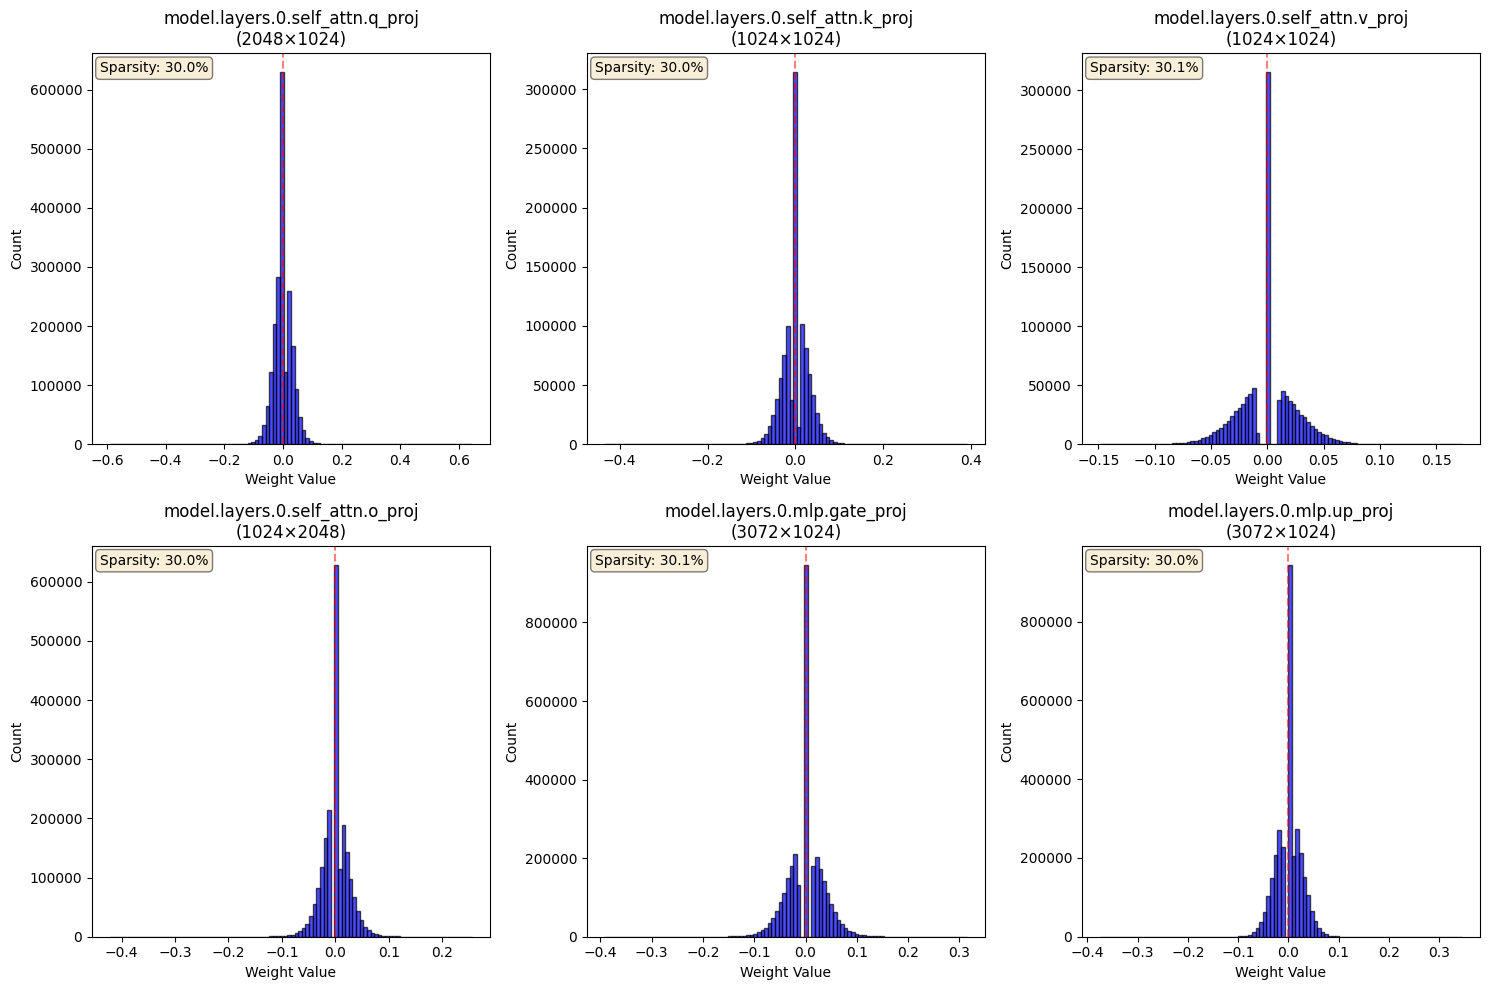

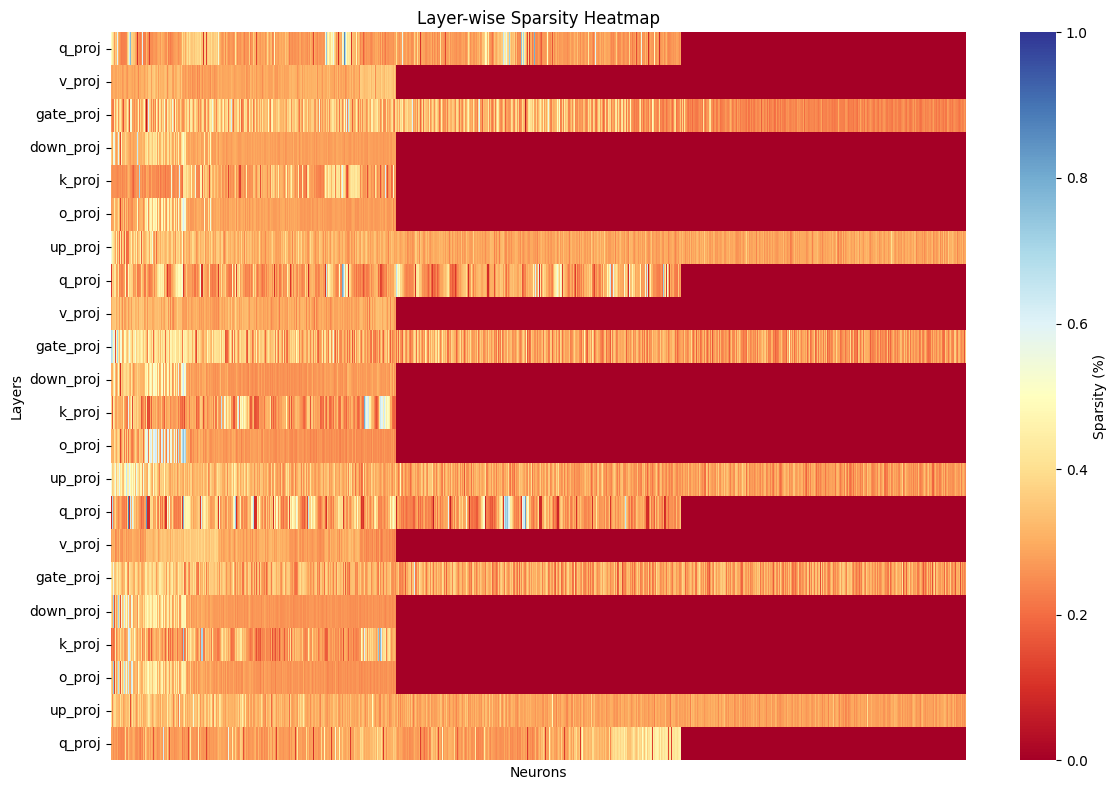


Создание отчета...
Измерение скорости оригинальной модели...


The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Измерение скорости инференса (10 запусков)...


The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature', 'top_p'

Измерение скорости прунингованной модели...
Измерение скорости инференса (10 запусков)...


The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature', 'top_p'


Отчет сохранен в pruning_report.html


In [4]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Dict, List, Tuple, Optional
from transformers import AutoModelForCausalLM
import pandas as pd


def analyze_layer_importance(model: nn.Module) -> pd.DataFrame:
    """
    Анализирует важность различных слоев модели на основе их весов.
    """
    layer_data = []
    
    for name, module in model.named_modules():
        if isinstance(module, nn.Linear):
            weight = module.weight.data
            
            # Вычисляем различные метрики
            metrics = {
                'layer_name': name,
                'shape': f"{weight.shape[0]}x{weight.shape[1]}",
                'total_params': weight.numel(),
                'mean_abs_weight': torch.abs(weight).mean().item(),
                'std_weight': weight.std().item(),
                'max_abs_weight': torch.abs(weight).max().item(),
                'sparsity': ((weight == 0).sum().item() / weight.numel()) * 100,
                'l2_norm': torch.norm(weight, p=2).item()
            }
            
            layer_data.append(metrics)
    
    return pd.DataFrame(layer_data)


def visualize_weight_distribution(model: nn.Module, 
                                layer_names: Optional[List[str]] = None,
                                num_layers: int = 6):
    """
    Визуализирует распределение весов в различных слоях.
    """
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.flatten()
    
    layer_count = 0
    for name, module in model.named_modules():
        if isinstance(module, nn.Linear):
            if layer_names and name not in layer_names:
                continue
                
            if layer_count >= num_layers:
                break
                
            weight = module.weight.data.cpu().numpy().flatten()
            
            # Гистограмма весов
            ax = axes[layer_count]
            ax.hist(weight, bins=100, alpha=0.7, color='blue', edgecolor='black')
            ax.axvline(x=0, color='red', linestyle='--', alpha=0.5)
            ax.set_title(f"{name}\n({module.weight.shape[0]}×{module.weight.shape[1]})")
            ax.set_xlabel('Weight Value')
            ax.set_ylabel('Count')
            
            # Добавляем статистику
            sparsity = (weight == 0).sum() / len(weight) * 100
            ax.text(0.02, 0.98, f'Sparsity: {sparsity:.1f}%', 
                   transform=ax.transAxes, va='top', ha='left',
                   bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
            
            layer_count += 1
    
    # Удаляем лишние подграфики
    for i in range(layer_count, len(axes)):
        fig.delaxes(axes[i])
    
    plt.tight_layout()
    plt.savefig('weight_distribution.png', dpi=300, bbox_inches='tight')
    plt.show()


def plot_sparsity_heatmap(model: nn.Module):
    """
    Создает тепловую карту разреженности по слоям модели.
    """
    layer_names = []
    sparsity_data = []
    
    for name, module in model.named_modules():
        if isinstance(module, nn.Linear):
            weight = module.weight.data
            sparsity = (weight == 0).float().mean(dim=1).cpu().numpy()
            
            layer_names.append(name.split('.')[-1])
            sparsity_data.append(sparsity)
    
    # Ограничиваем количество слоев для визуализации
    if len(layer_names) > 20:
        step = len(layer_names) // 20
        layer_names = layer_names[::step]
        sparsity_data = sparsity_data[::step]
    
    # Создаем тепловую карту
    plt.figure(figsize=(12, 8))
    
    # Преобразуем данные для отображения
    max_len = max(len(s) for s in sparsity_data)
    heatmap_data = np.zeros((len(sparsity_data), max_len))
    
    for i, sparsity in enumerate(sparsity_data):
        heatmap_data[i, :len(sparsity)] = sparsity
    
    sns.heatmap(heatmap_data, 
                xticklabels=False,
                yticklabels=layer_names,
                cmap='RdYlBu',
                cbar_kws={'label': 'Sparsity (%)'},
                vmin=0, vmax=1)
    
    plt.title('Layer-wise Sparsity Heatmap')
    plt.xlabel('Neurons')
    plt.ylabel('Layers')
    plt.tight_layout()
    plt.savefig('sparsity_heatmap.png', dpi=300, bbox_inches='tight')
    plt.show()


def compare_models_before_after(original_model: nn.Module, 
                              pruned_model: nn.Module,
                              layer_name: str):
    """
    Сравнивает веса конкретного слоя до и после прунинга.
    """
    # Получаем веса слоя
    original_weight = None
    pruned_weight = None
    
    for name, module in original_model.named_modules():
        if name == layer_name and isinstance(module, nn.Linear):
            original_weight = module.weight.data.cpu().numpy()
            break
    
    for name, module in pruned_model.named_modules():
        if name == layer_name and isinstance(module, nn.Linear):
            pruned_weight = module.weight.data.cpu().numpy()
            break
    
    if original_weight is None or pruned_weight is None:
        print(f"Слой {layer_name} не найден!")
        return
    
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    # Оригинальные веса
    im1 = axes[0].imshow(original_weight[:50, :50], cmap='seismic', aspect='auto')
    axes[0].set_title('Original Weights')
    axes[0].set_xlabel('Input Dimension')
    axes[0].set_ylabel('Output Dimension')
    plt.colorbar(im1, ax=axes[0])
    
    # Прунингованные веса
    im2 = axes[1].imshow(pruned_weight[:50, :50], cmap='seismic', aspect='auto')
    axes[1].set_title('Pruned Weights')
    axes[1].set_xlabel('Input Dimension')
    axes[1].set_ylabel('Output Dimension')
    plt.colorbar(im2, ax=axes[1])
    
    # Маска прунинга
    mask = (pruned_weight != 0).astype(float)
    im3 = axes[2].imshow(mask[:50, :50], cmap='binary', aspect='auto')
    axes[2].set_title('Pruning Mask (white=kept, black=pruned)')
    axes[2].set_xlabel('Input Dimension')
    axes[2].set_ylabel('Output Dimension')
    plt.colorbar(im3, ax=axes[2])
    
    plt.suptitle(f'Layer: {layer_name}')
    plt.tight_layout()
    plt.savefig(f'layer_comparison_{layer_name.replace(".", "_")}.png', dpi=300)
    plt.show()


def measure_inference_speed(model: nn.Module, 
                          tokenizer,
                          test_texts: List[str],
                          num_runs: int = 10,
                          device: str = 'cuda'):
    """
    Измеряет скорость инференса модели.
    """
    import time
    
    model.eval()
    model = model.to(device)
    
    times = []
    tokens_generated = []
    
    print(f"Измерение скорости инференса ({num_runs} запусков)...")
    
    for i in range(num_runs):
        text = test_texts[i % len(test_texts)]
        inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True)
        inputs = {k: v.to(device) for k, v in inputs.items()}
        
        start_time = time.time()
        with torch.no_grad():
            outputs = model.generate(
                **inputs,
                max_new_tokens=50,
                do_sample=False,
                pad_token_id=tokenizer.eos_token_id
            )
        end_time = time.time()
        
        times.append(end_time - start_time)
        tokens_generated.append(outputs.shape[1] - inputs['input_ids'].shape[1])
    
    avg_time = np.mean(times)
    avg_tokens = np.mean(tokens_generated)
    tokens_per_second = avg_tokens / avg_time
    
    return {
        'avg_time': avg_time,
        'std_time': np.std(times),
        'avg_tokens': avg_tokens,
        'tokens_per_second': tokens_per_second
    }


def create_pruning_report(model_name: str,
                        original_model: nn.Module,
                        pruned_model: nn.Module,
                        tokenizer,
                        output_file: str = 'pruning_report.html'):
    """
    Создает подробный HTML отчет о результатах прунинга.
    """
    
    # Собираем информацию
    original_size = calculate_model_size(original_model)
    pruned_size = calculate_model_size(pruned_model)
    sparsity_info = calculate_sparsity(pruned_model)
    
    # Тестовые тексты для измерения скорости
    test_texts = [
        "The weather today is",
        "Artificial intelligence can",
        "In the future, we will"
    ]
    
    # Измеряем скорость
    print("Измерение скорости оригинальной модели...")
    original_speed = measure_inference_speed(original_model, tokenizer, test_texts)
    
    print("Измерение скорости прунингованной модели...")
    pruned_speed = measure_inference_speed(pruned_model, tokenizer, test_texts)
    
    # Создаем HTML отчет
    html_content = f"""
    <!DOCTYPE html>
    <html>
    <head>
        <title>Pruning Report - {model_name}</title>
        <style>
            body {{ font-family: Arial, sans-serif; margin: 40px; }}
            h1 {{ color: #333; }}
            h2 {{ color: #666; }}
            table {{ border-collapse: collapse; width: 100%; margin: 20px 0; }}
            th, td {{ border: 1px solid #ddd; padding: 12px; text-align: left; }}
            th {{ background-color: #f2f2f2; }}
            .metric {{ font-size: 24px; font-weight: bold; color: #2196F3; }}
            .improvement {{ color: #4CAF50; }}
            .degradation {{ color: #f44336; }}
        </style>
    </head>
    <body>
        <h1>Отчет о прунинге модели {model_name}</h1>
        
        <h2>Общая информация</h2>
        <table>
            <tr>
                <th>Метрика</th>
                <th>До прунинга</th>
                <th>После прунинга</th>
                <th>Изменение</th>
            </tr>
            <tr>
                <td>Всего параметров</td>
                <td>{original_size['total_params']:,}</td>
                <td>{pruned_size['total_params']:,}</td>
                <td>0%</td>
            </tr>
            <tr>
                <td>Активных параметров</td>
                <td>{original_size['total_params']:,}</td>
                <td>{sparsity_info['remaining_params']:,}</td>
                <td class="improvement">-{100 - sparsity_info['remaining_percentage']:.1f}%</td>
            </tr>
            <tr>
                <td>Размер модели (MB)</td>
                <td>{original_size['size_mb']:.2f}</td>
                <td>{pruned_size['effective_size_mb']:.2f}</td>
                <td class="improvement">-{(1 - pruned_size['effective_size_mb']/original_size['size_mb'])*100:.1f}%</td>
            </tr>
            <tr>
                <td>Разреженность</td>
                <td>0%</td>
                <td>{sparsity_info['sparsity_percentage']:.1f}%</td>
                <td>+{sparsity_info['sparsity_percentage']:.1f}%</td>
            </tr>
        </table>
        
        <h2>Производительность</h2>
        <table>
            <tr>
                <th>Метрика</th>
                <th>До прунинга</th>
                <th>После прунинга</th>
                <th>Изменение</th>
            </tr>
            <tr>
                <td>Средняя скорость генерации (сек)</td>
                <td>{original_speed['avg_time']:.3f}</td>
                <td>{pruned_speed['avg_time']:.3f}</td>
                <td class="{'improvement' if pruned_speed['avg_time'] < original_speed['avg_time'] else 'degradation'}">
                    {((pruned_speed['avg_time'] - original_speed['avg_time'])/original_speed['avg_time']*100):+.1f}%
                </td>
            </tr>
            <tr>
                <td>Токенов в секунду</td>
                <td>{original_speed['tokens_per_second']:.1f}</td>
                <td>{pruned_speed['tokens_per_second']:.1f}</td>
                <td class="{'improvement' if pruned_speed['tokens_per_second'] > original_speed['tokens_per_second'] else 'degradation'}">
                    {((pruned_speed['tokens_per_second'] - original_speed['tokens_per_second'])/original_speed['tokens_per_second']*100):+.1f}%
                </td>
            </tr>
        </table>
        
        <h2>Итоги</h2>
        <p class="metric">Достигнутая разреженность: {sparsity_info['sparsity_percentage']:.1f}%</p>
        <p class="metric">Эффективное сжатие: {(1 - pruned_size['effective_size_mb']/original_size['size_mb'])*100:.1f}%</p>
        <p class="metric">Ускорение: {((pruned_speed['tokens_per_second'] - original_speed['tokens_per_second'])/original_speed['tokens_per_second']*100):+.1f}%</p>
        
        <p><em>Отчет сгенерирован автоматически</em></p>
    </body>
    </html>
    """
    
    with open(output_file, 'w', encoding='utf-8') as f:
        f.write(html_content)
    
    print(f"\nОтчет сохранен в {output_file}")
    return output_file


# Пример использования
if __name__ == "__main__":    
    # Загружаем модели для сравнения
    model_name = "Qwen/Qwen3-0.6B"
    
    print("Загрузка оригинальной модели...")
    original_model = AutoModelForCausalLM.from_pretrained(
        model_name,
        torch_dtype=torch.float32,
        trust_remote_code=True
    )
    
    print("Применение прунинга...")
    pruned_model, tokenizer = prune_llm_model(
        model_name,
        pruning_config={
            'method': 'magnitude',
            'sparsity': 0.3,
            'iterative': True,
            'iterations': 3
        },
        return_tokenizer=True
    )
    
    # Анализ важности слоев
    print("\nАнализ важности слоев...")
    layer_importance = analyze_layer_importance(pruned_model)
    print(layer_importance.head(10))
    
    # Визуализация
    print("\nСоздание визуализаций...")
    visualize_weight_distribution(pruned_model)
    plot_sparsity_heatmap(pruned_model)
    
    # Создание отчета
    print("\nСоздание отчета...")
    create_pruning_report(model_name, original_model, pruned_model, tokenizer)

# True pruning (structural)

In [7]:
import torch
import torch.nn as nn
from transformers import AutoModelForCausalLM, AutoTokenizer
import numpy as np
from typing import Dict, Any, Tuple, Optional
import gc
import os
import psutil
from copy import deepcopy


class StructuralPruner:
    """Класс для структурного прунинга LLM моделей"""
    
    def __init__(self, model, importance_metric='l2_norm'):
        self.model = model
        self.importance_metric = importance_metric
        self.model_config = model.config
        
    def compute_importance_scores(self, layer_type='attention_heads'):
        """Вычисление важности компонентов модели"""
        importance_scores = {}
        
        if layer_type == 'attention_heads':
            # Вычисляем важность для каждой attention head
            for name, module in self.model.named_modules():
                if all(hasattr(module, a) for a in ('num_heads','head_dim','q_proj','k_proj','v_proj')):
                    q_weight = module.q_proj.weight
                    k_weight = module.k_proj.weight
                    v_weight = module.v_proj.weight
                    
                    # Reshape для анализа по головам
                    num_heads = module.num_heads
                    head_dim = module.head_dim
                    
                    q_heads = q_weight.view(num_heads, head_dim, -1)
                    k_heads = k_weight.view(num_heads, head_dim, -1)
                    v_heads = v_weight.view(num_heads, head_dim, -1)
                    
                    # Вычисляем L2 норму для каждой головы
                    head_scores = []
                    for i in range(num_heads):
                        if self.importance_metric == 'l2_norm':
                            score = (torch.norm(q_heads[i]) + 
                                   torch.norm(k_heads[i]) + 
                                   torch.norm(v_heads[i])).item()
                        head_scores.append(score)
                    
                    importance_scores[name] = head_scores
                    
        elif layer_type == 'ffn_neurons':
            # Вычисляем важность для нейронов FFN
            for name, module in self.model.named_modules():
                if isinstance(module, nn.Linear) and ('mlp' in name or 'ffn' in name):
                    if 'gate_proj' in name or 'up_proj' in name or 'fc1' in name:
                        weight = module.weight
                        # Вычисляем важность каждого нейрона
                        neuron_scores = torch.norm(weight, dim=1).cpu().numpy()
                        importance_scores[name] = neuron_scores
                        
        return importance_scores
    
    def prune_attention_heads(self, prune_ratio=0.3):
        """Прунинг attention heads"""
        importance_scores = self.compute_importance_scores('attention_heads')
        
        # Собираем все scores и определяем порог
        # in prune_attention_heads
        all_scores = []
        for scores in importance_scores.values():
            all_scores.extend(scores)
        
        if len(all_scores) == 0:
            # nothing found → skip
            print("Warning: no attention heads detected, skipping head pruning.")
            return {}
        
        threshold = np.percentile(all_scores, prune_ratio * 100)
        
        # Определяем какие головы удалять
        heads_to_prune = {}
        for layer_name, scores in importance_scores.items():
            heads_to_keep = [i for i, score in enumerate(scores) if score > threshold]
            if len(heads_to_keep) < len(scores):
                heads_to_prune[layer_name] = heads_to_keep
                
        return heads_to_prune
    
    def prune_ffn_neurons(self, prune_ratio=0.3):
        """Прунинг нейронов в FFN слоях"""
        importance_scores = self.compute_importance_scores('ffn_neurons')
        
        # Определяем порог для прунинга
        # in prune_ffn_neurons
        all_scores = []
        for scores in importance_scores.values():
            all_scores.extend(scores)
        
        if len(all_scores) == 0:
            print("Warning: no FFN neurons detected, skipping FFN pruning.")
            return {}
        
        threshold = np.percentile(all_scores, prune_ratio * 100)
        
        # Определяем какие нейроны оставить
        neurons_to_keep = {}
        for layer_name, scores in importance_scores.items():
            keep_indices = np.where(scores > threshold)[0]
            if len(keep_indices) < len(scores):
                neurons_to_keep[layer_name] = keep_indices
                
        return neurons_to_keep
    
    def apply_pruning(self, heads_to_prune=None, neurons_to_keep=None):
        """Применение структурного прунинга к модели"""
        
        # Прунинг attention heads
        if heads_to_prune:
            for name, module in self.model.named_modules():
                if name in heads_to_prune:
                    heads_to_keep = heads_to_prune[name]
                    num_heads = module.num_heads
                    head_dim = module.head_dim
                    
                    # Создаем новые веса только для оставшихся голов
                    new_num_heads = len(heads_to_keep)
                    
                    # Обновляем Q, K, V проекции
                    for proj_name in ['q_proj', 'k_proj', 'v_proj']:
                        if hasattr(module, proj_name):
                            proj = getattr(module, proj_name)
                            old_weight = proj.weight.data
                            
                            # Reshape и выбираем нужные головы
                            old_weight_reshaped = old_weight.view(num_heads, head_dim, -1)
                            new_weight = old_weight_reshaped[heads_to_keep].reshape(new_num_heads * head_dim, -1)
                            
                            # Создаем новый Linear слой
                            new_proj = nn.Linear(proj.in_features, new_num_heads * head_dim, bias=proj.bias is not None)
                            new_proj.weight.data = new_weight
                            
                            if proj.bias is not None:
                                old_bias_reshaped = proj.bias.view(num_heads, head_dim)
                                new_bias = old_bias_reshaped[heads_to_keep].reshape(-1)
                                new_proj.bias.data = new_bias
                            
                            setattr(module, proj_name, new_proj)
                    
                    # Обновляем output projection
                    if hasattr(module, 'o_proj'):
                        o_proj = module.o_proj
                        old_weight = o_proj.weight.data
                        
                        # Выбираем соответствующие столбцы
                        indices = []
                        for i in heads_to_keep:
                            indices.extend(range(i * head_dim, (i + 1) * head_dim))
                        
                        new_weight = old_weight[:, indices]
                        new_o_proj = nn.Linear(new_num_heads * head_dim, o_proj.out_features, bias=o_proj.bias is not None)
                        new_o_proj.weight.data = new_weight
                        
                        if o_proj.bias is not None:
                            new_o_proj.bias.data = o_proj.bias.data
                            
                        module.o_proj = new_o_proj
                    
                    # Обновляем конфигурацию
                    module.num_heads = new_num_heads
        
        # Прунинг FFN нейронов
        if neurons_to_keep:
            for name, module in self.model.named_modules():
                if name in neurons_to_keep:
                    keep_indices = neurons_to_keep[name]
                    
                    # Обновляем веса
                    old_weight = module.weight.data
                    new_weight = old_weight[keep_indices]
                    
                    new_module = nn.Linear(module.in_features, len(keep_indices), bias=module.bias is not None)
                    new_module.weight.data = new_weight
                    
                    if module.bias is not None:
                        new_module.bias.data = module.bias.data[keep_indices]
                    
                    # Заменяем модуль
                    parent_name = '.'.join(name.split('.')[:-1])
                    child_name = name.split('.')[-1]
                    parent = self.model
                    for part in parent_name.split('.'):
                        if part:
                            parent = getattr(parent, part)
                    setattr(parent, child_name, new_module)
                    
                    # Обновляем соответствующий down projection
                    down_name = name.replace('gate_proj', 'down_proj').replace('up_proj', 'down_proj').replace('fc1', 'fc2')
                    if down_name != name:
                        for dn, dm in self.model.named_modules():
                            if dn == down_name and isinstance(dm, nn.Linear):
                                old_down_weight = dm.weight.data
                                new_down_weight = old_down_weight[:, keep_indices]
                                
                                new_down = nn.Linear(len(keep_indices), dm.out_features, bias=dm.bias is not None)
                                new_down.weight.data = new_down_weight
                                
                                if dm.bias is not None:
                                    new_down.bias.data = dm.bias.data
                                
                                parent_name = '.'.join(dn.split('.')[:-1])
                                child_name = dn.split('.')[-1]
                                parent = self.model
                                for part in parent_name.split('.'):
                                    if part:
                                        parent = getattr(parent, part)
                                setattr(parent, child_name, new_down)


def structural_prune_llm(model, prune_params: Dict[str, Any]) -> nn.Module:
    """
    Функция для структурного прунинга LLM модели
    
    Args:
        model: Любая LLM модель из transformers
        prune_params: Параметры прунинга
            - attention_prune_ratio: доля attention heads для удаления (0-1)
            - ffn_prune_ratio: доля FFN нейронов для удаления (0-1)
            - importance_metric: метрика важности ('l2_norm')
    
    Returns:
        Прунингованная модель
    """
    # Создаем копию модели для безопасности
    pruned_model = deepcopy(model)
    pruned_model.eval()
    
    # Инициализируем pruner
    pruner = StructuralPruner(pruned_model, prune_params.get('importance_metric', 'l2_norm'))
    
    # Прунинг attention heads
    if prune_params.get('attention_prune_ratio', 0) > 0:
        heads_to_prune = pruner.prune_attention_heads(prune_params['attention_prune_ratio'])
        pruner.apply_pruning(heads_to_prune=heads_to_prune)
    
    # Прунинг FFN нейронов
    if prune_params.get('ffn_prune_ratio', 0) > 0:
        neurons_to_keep = pruner.prune_ffn_neurons(prune_params['ffn_prune_ratio'])
        pruner.apply_pruning(neurons_to_keep=neurons_to_keep)
    
    return pruned_model


def get_model_size(model):
    """Получение размера модели в памяти"""
    param_size = 0
    for param in model.parameters():
        param_size += param.nelement() * param.element_size()
    
    buffer_size = 0
    for buffer in model.buffers():
        buffer_size += buffer.nelement() * buffer.element_size()
    
    size_mb = (param_size + buffer_size) / 1024 / 1024
    
    # Подсчет параметров
    total_params = sum(p.numel() for p in model.parameters())
    
    return size_mb, total_params


def test_pruning():
    """Тестирование функции прунинга на модели Qwen/Qwen2.5-0.5B"""
    print("Загрузка модели Qwen/Qwen2.5-0.5B...")
    
    # Используем меньшую модель для тестирования
    model_name = "Qwen/Qwen3-0.6B"
    
    # Загружаем модель и токенизатор
    model = AutoModelForCausalLM.from_pretrained(
        model_name, 
        torch_dtype=torch.float16,
        device_map="cpu"
    )
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    
    # Измеряем исходный размер
    original_size_mb, original_params = get_model_size(model)
    print(f"\nИсходная модель:")
    print(f"  Размер в памяти: {original_size_mb:.2f} MB")
    print(f"  Количество параметров: {original_params:,}")
    
    # Параметры прунинга
    prune_params = {
        'attention_prune_ratio': 0.3,  # Удаляем 30% attention heads
        'ffn_prune_ratio': 0.3,        # Удаляем 30% FFN нейронов
        'importance_metric': 'l2_norm'
    }
    
    print(f"\nПрименяем структурный прунинг с параметрами: {prune_params}")
    
    # Применяем прунинг
    pruned_model = structural_prune_llm(model, prune_params)
    
    # Измеряем новый размер
    pruned_size_mb, pruned_params = get_model_size(pruned_model)
    print(f"\nПрунингованная модель:")
    print(f"  Размер в памяти: {pruned_size_mb:.2f} MB")
    print(f"  Количество параметров: {pruned_params:,}")
    
    # Вычисляем сокращение
    size_reduction = (1 - pruned_size_mb / original_size_mb) * 100
    param_reduction = (1 - pruned_params / original_params) * 100
    
    print(f"\nСокращение:")
    print(f"  Размер уменьшен на: {size_reduction:.1f}%")
    print(f"  Параметры уменьшены на: {param_reduction:.1f}%")
    
    # Тест генерации текста
    print("\nТестируем генерацию текста...")
    test_prompt = "The future of AI is"
    
    # Исходная модель
    inputs = tokenizer(test_prompt, return_tensors="pt")
    with torch.no_grad():
        original_output = model.generate(**inputs, max_length=50, do_sample=False)
    original_text = tokenizer.decode(original_output[0], skip_special_tokens=True)
    
    # Прунингованная модель
    with torch.no_grad():
        pruned_output = pruned_model.generate(**inputs, max_length=50, do_sample=False)
    pruned_text = tokenizer.decode(pruned_output[0], skip_special_tokens=True)
    
    print(f"\nИсходная модель: {original_text}")
    print(f"\nПрунингованная модель: {pruned_text}")
    
    # Сохранение модели для проверки размера на диске
    print("\nСохраняем модели для проверки размера на диске...")
    
    # Сохраняем исходную модель
    original_path = "original_model"
    model.save_pretrained(original_path)
    
    # Сохраняем прунингованную модель
    pruned_path = "pruned_model"
    pruned_model.save_pretrained(pruned_path)
    
    # Сравниваем размеры на диске
    original_disk_size = sum(os.path.getsize(os.path.join(original_path, f)) for f in os.listdir(original_path) if f.endswith('.bin') or f.endswith('.safetensors')) / 1024 / 1024
    pruned_disk_size = sum(os.path.getsize(os.path.join(pruned_path, f)) for f in os.listdir(pruned_path) if f.endswith('.bin') or f.endswith('.safetensors')) / 1024 / 1024
    
    print(f"\nРазмер на диске:")
    print(f"  Исходная модель: {original_disk_size:.2f} MB")
    print(f"  Прунингованная модель: {pruned_disk_size:.2f} MB")
    print(f"  Сокращение: {(1 - pruned_disk_size / original_disk_size) * 100:.1f}%")
    
    # Очистка
    import shutil
    shutil.rmtree(original_path)
    shutil.rmtree(pruned_path)
    
    return pruned_model


if __name__ == "__main__":
    # Запускаем тестирование
    pruned_model = test_pruning()

Загрузка модели Qwen/Qwen2.5-0.5B...

Исходная модель:
  Размер в памяти: 1136.88 MB
  Количество параметров: 596,049,920

Применяем структурный прунинг с параметрами: {'attention_prune_ratio': 0.3, 'ffn_prune_ratio': 0.3, 'importance_metric': 'l2_norm'}


RuntimeError: Can't call numpy() on Tensor that requires grad. Use tensor.detach().numpy() instead.